In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential


In [3]:
train_ids = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Super AI Homework/Week 3/super-ai-image-classification/train/train/train.csv')
train_ids.head()

,id,category
0,6380fb87-18fe-4b76-a085-639a4e01b664.jpg,0
1,9956035b-0500-47b7-b508-cc7414c10270.jpg,0
2,fa6b4604-a080-410b-a8d1-fdf7cf61a92d.jpg,0
3,6e6dc67b-73ba-404b-b685-1f726d0357c3.jpg,0
4,15121f8e-f428-4cd5-83bf-1c9a051aea54.jpg,0


In [4]:
train_ids['category'].value_counts()

0    1317
1     408
Name: category, dtype: int64

In [5]:
def del_imba(train_ids):
  rd = np.random.permutation(train_ids[train_ids['category'] == 0].index)
  X0 = rd[:408]
  X0 = list(X0)
  X1 = train_ids[train_ids['category'] == 1].index
  X1 = list(X1)
  for i in X1:
      X0.append(i)
  X_train_samp = train_ids.loc[X0]
  return X_train_samp

In [6]:
train_ids_ba = del_imba(train_ids)
train_ids_ba['category'].value_counts()

1    408
0    408
Name: category, dtype: int64

In [7]:
def X_prep(ids):
    print("Preparing images")
    print('*'*16)
    batches = train_ids_ba.shape[0]
    data_prep = np.zeros((batches, 224, 224, 3))
    count = 0
    #duplicated = 0
    for i in ids['id']:
      #load images into images of size 100x100x3
      img = image.load_img('/content/drive/My Drive/Colab Notebooks/Super AI Homework/Week 3/super-ai-image-classification/train/train/images'+'/'+i, target_size=(224, 224, 3))
      x = image.img_to_array(img)
      x = preprocess_input(x)
      
      #if x in data_prep:
      #  duplicated += 1
      #  continue
      data_prep[count] = x
      if (count%100 == 0) and count != 0:
        print("Finished:", count)
      elif count == (batches-1):
        print("Finished:", batches)
      count += 1
    #print('Duplicated:', duplicated)
    return data_prep

In [8]:
X = X_prep(train_ids_ba)

Preparing images
****************
Finished: 100
Finished: 200
Finished: 300
Finished: 400
Finished: 500
Finished: 600
Finished: 700
Finished: 800
Finished: 816


In [9]:
X.shape

(816, 224, 224, 3)

In [10]:
Y = np.array(train_ids_ba['category'])
Y.shape

(816,)

In [9]:
type(Y)

numpy.ndarray

In [11]:
#split train test
idx = np.random.permutation(np.arange(len(X)))
split = 816 * 8 // 10
train_idx = idx[:split]
test_idx = idx[split:]
X_train, Y_train = X[train_idx] / 255., Y[train_idx].astype(np.int)
X_test, Y_test = X[test_idx] / 255., Y[test_idx].astype(np.int)

In [17]:
X_train.shape

(652, 224, 224, 3)

In [18]:
X_test.shape

(164, 224, 224, 3)

In [22]:
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

vgg = ResNet101(include_top=False, weights='imagenet')
# fit input
x_in = layers.Input(shape=(224, 224, 3))
#x = layers.Conv2D(3, 1)(x_in) #ใช้convแปลง
x = vgg(x_in)
# fit output
x = layers.Flatten()(x)
#x = layers.Dense(1, activation = 'sigmoid')(x)
#x = layers.Dense(2, activation= 'relu')(x)
x = layers.Dense(2, activation='softmax')(x)
model = Model(x_in, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, None, None, 2048)  42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 42,858,882
Trainable params: 42,753,538
Non-trainable params: 105,344
_________________________________________________________________


In [26]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [27]:
# fits the model on batches with real-time data augmentation:
epochs = 100
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=epochs)

Epoch 1/100
21/20 [==============================] - 24s 1s/step - loss: 0.6655
Epoch 2/100
21/20 [==============================] - 24s 1s/step - loss: 0.4215
Epoch 3/100
21/20 [==============================] - 24s 1s/step - loss: 0.1621
Epoch 4/100
21/20 [==============================] - 24s 1s/step - loss: 0.1368
Epoch 5/100
21/20 [==============================] - 24s 1s/step - loss: 0.0784
Epoch 6/100
21/20 [==============================] - 24s 1s/step - loss: 0.0288
Epoch 7/100
21/20 [==============================] - 24s 1s/step - loss: 0.0343
Epoch 8/100
21/20 [==============================] - 24s 1s/step - loss: 0.0653
Epoch 9/100
21/20 [==============================] - 24s 1s/step - loss: 0.0185
Epoch 10/100
21/20 [==============================] - 24s 1s/step - loss: 0.0125
Epoch 11/100
21/20 [==============================] - 24s 1s/step - loss: 0.0036
Epoch 12/100
21/20 [==============================] - 24s 1s/step - loss: 0.0127
Epoch 13/100
21/20 [=================

In [15]:
import tensorflow as tf

In [ ]:
#ของเก่า
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001))
history = model.fit(X_train, Y_train, epochs=500)

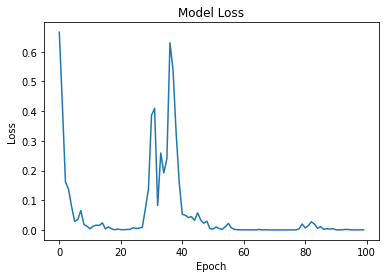

In [28]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [29]:
#save weights
model.save('model.h5')
model.save_weights(filepath = 'weights')

In [30]:
#load saved model
from keras.models import load_model
model = load_model('./model.h5')

In [31]:
#predict
Z_test = model.predict(X_test)
pred = Z_test.argmax(axis=1)

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [33]:
confusion_matrix(Y_test, pred)

array([[78,  8],
       [11, 67]])

In [34]:
print('Accuracy = ', accuracy_score(Y_test, pred))
print('F1-Score = ', f1_score(Y_test, pred))
print('Precision = ', precision_score(Y_test, pred))
print('Recall = ', recall_score(Y_test, pred))

Accuracy =  0.8841463414634146
F1-Score =  0.8758169934640523
Precision =  0.8933333333333333
Recall =  0.8589743589743589


In [35]:
pred

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0])

# Evaluation

In [12]:
import glob

def get_data_ids():
  print("Preparing Images")
  print('*'*16)
  imgVal = glob.glob("/content/drive/My Drive/Colab Notebooks/Super AI Homework/Week 3/super-ai-image-classification/val/val/images/*.jpg")
  data_prep = np.zeros((len(imgVal), 224, 224, 3))
  count = 0

  ids_lst = []
  for i in imgVal:
    head, tail = os.path.split(i)
    #print(tail)
    ids_lst.append(tail)
  ids_lst = np.array(ids_lst)

  for i in imgVal:
    img = image.load_img(i, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    
    data_prep[count] = x
    if (count%100 == 0) and count != 0:
      print("Finished:", count)
    elif count == (len(imgVal)-1):
      print("Finished:", len(imgVal))
    count += 1
      
  return data_prep, ids_lst

In [13]:
def get_valids():
  imgVal = glob.glob("/content/drive/My Drive/Colab Notebooks/Super AI Homework/Week 3/super-ai-image-classification/val/val/images/*.jpg")
  ids_lst = []
  for i in mgVal:
    head, tail = os.path.split(i)
    #print(tail)
    ids_lst.append(tail)
  ids_lst = np.array(ids_lst)
  return ids_lst

In [14]:
data_val, ids_val = get_data_ids()

Preparing Images
****************
Finished: 100
Finished: 200
Finished: 300
Finished: 398


In [15]:
X_train_val, Y_train_val = X / 255., Y.astype(np.int)

In [16]:
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

vgg = ResNet101(include_top=False, weights='imagenet')
# fit input
x_in = layers.Input(shape=(224, 224, 3))
#x = layers.Conv2D(3, 1)(x_in) #ใช้convแปลง
x = vgg(x_in)
# fit output
x = layers.Flatten()(x)
#x = layers.Dense(1, activation = 'sigmoid')(x)
#x = layers.Dense(2, activation= 'relu')(x)
x = layers.Dense(2, activation='softmax')(x)
model = Model(x_in, x)
model.summary()

171450368/171446536 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, None, None, 2048)  42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 200706    
Total params: 42,858,882
Trainable params: 42,753,538
Non-trainable params: 105,344
_________________________________________________________________


In [17]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_val)

In [ ]:
# fits the model on batches with real-time data augmentation:
epochs = 100
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(datagen.flow(X_train_val, Y_train_val, batch_size=32),
          steps_per_epoch=len(X_train_val) / 32, epochs=epochs)

Epoch 1/100
23/25 [==========================>...] - ETA: 1:28 - loss: 0.8944

In [ ]:
#save weights
model.save('model.h5')
model.save_weights(filepath = 'weights')

In [ ]:
#load saved model
from keras.models import load_model
model = load_model('./model.h5')

In [ ]:
#ของเก่า
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001))
model.fit(X_train_val, Y_train_val, epochs=500)

In [85]:
#Predict
Z_val = model.predict(data_val)
pred_val = Z_val.argmax(axis=1)

In [86]:
pred_val

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,

In [102]:
val_ids = get_valids()

In [2]:
Answer = pd.DataFrame({'id': val_ids,
                   'category': pred_val})
Answer

NameError: ignored

In [106]:
Answer.to_csv(r'/content/drive/My Drive/Colab Notebooks/Super AI Homework/Week 3/Answer.csv', index=False)